## Table of Contents

<ol>
    <li>
        <a href="#Introduction">Introduction</a>
    </li>
    <li>
        <a href="#Picking-a-pretrained-model-for-masked-language-modeling">Picking a pretrained model for masked language modeling</a>
    </li>
    <li>
        <a href="#The-dataset">The dataset</a>
    </li>
    <li>
        <a href="#Preprocessing-the-data">Preprocessing the data</a>
    </li>
    <li>
        <a href="#Fine-tuning DistilBERT-with-the-Trainer-API">Fine-tuning DistilBERT with the Trainer API</a>
    </li>
    <li>
        <a href="#Using-our-fine-tuned-model">Fine-tuning the model</a>
    </li>
    <li>
        <a href="#Fine-tuning-DistilBERT-with-🤗-Accelerate">Fine-tuning DistilBERT with 🤗 Accelerate</a>
    </li>
</ol>

## Introduction

For many NLP applications involving Transformer models, you can simply take a pretrained model from the Hugging Face Hub and fine-tune it directly on your data for the task at hand. Provided that the corpus used for pretraining is not too different from the corpus used for fine-tuning, transfer learning will usually produce good results.

However, there are a few cases where you’ll want to first fine-tune the language models on your data, before training a task-specific head. For example, if your dataset contains legal contracts or scientific articles, a vanilla Transformer model like BERT will typically treat the domain-specific words in your corpus as rare tokens, and the resulting performance may be less than satisfactory. By fine-tuning the language model on in-domain data you can boost the performance of many downstream tasks, which means you usually only have to do this step once!

This process of fine-tuning a pretrained language model on in-domain data is usually called *domain adaptation*. It was popularized in 2018 by [ULMFiT](https://arxiv.org/abs/1801.06146), which was one of the first neural architectures (based on LSTMs) to make transfer learning really work for NLP. An example of domain adaptation with ULMFiT is shown in the image below; in this section we’ll do something similar, but with a Transformer instead of an LSTM!


![img](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter7/ulmfit-dark.svg)

By the end of this section you’ll have a [masked language model](https://huggingface.co/huggingface-course/distilbert-base-uncased-finetuned-imdb?text=This+is+a+great+%5BMASK%5D.) on the Hub that can autocomplete sentences as shown below:

Let’s dive in!

## Picking a pretrained model for masked language modeling 

To get started, let’s pick a suitable pretrained model for masked language modeling. As shown in the following screenshot, you can find a list of candidates by applying the “Fill-Mask” filter on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=fill-mask&sort=downloads):

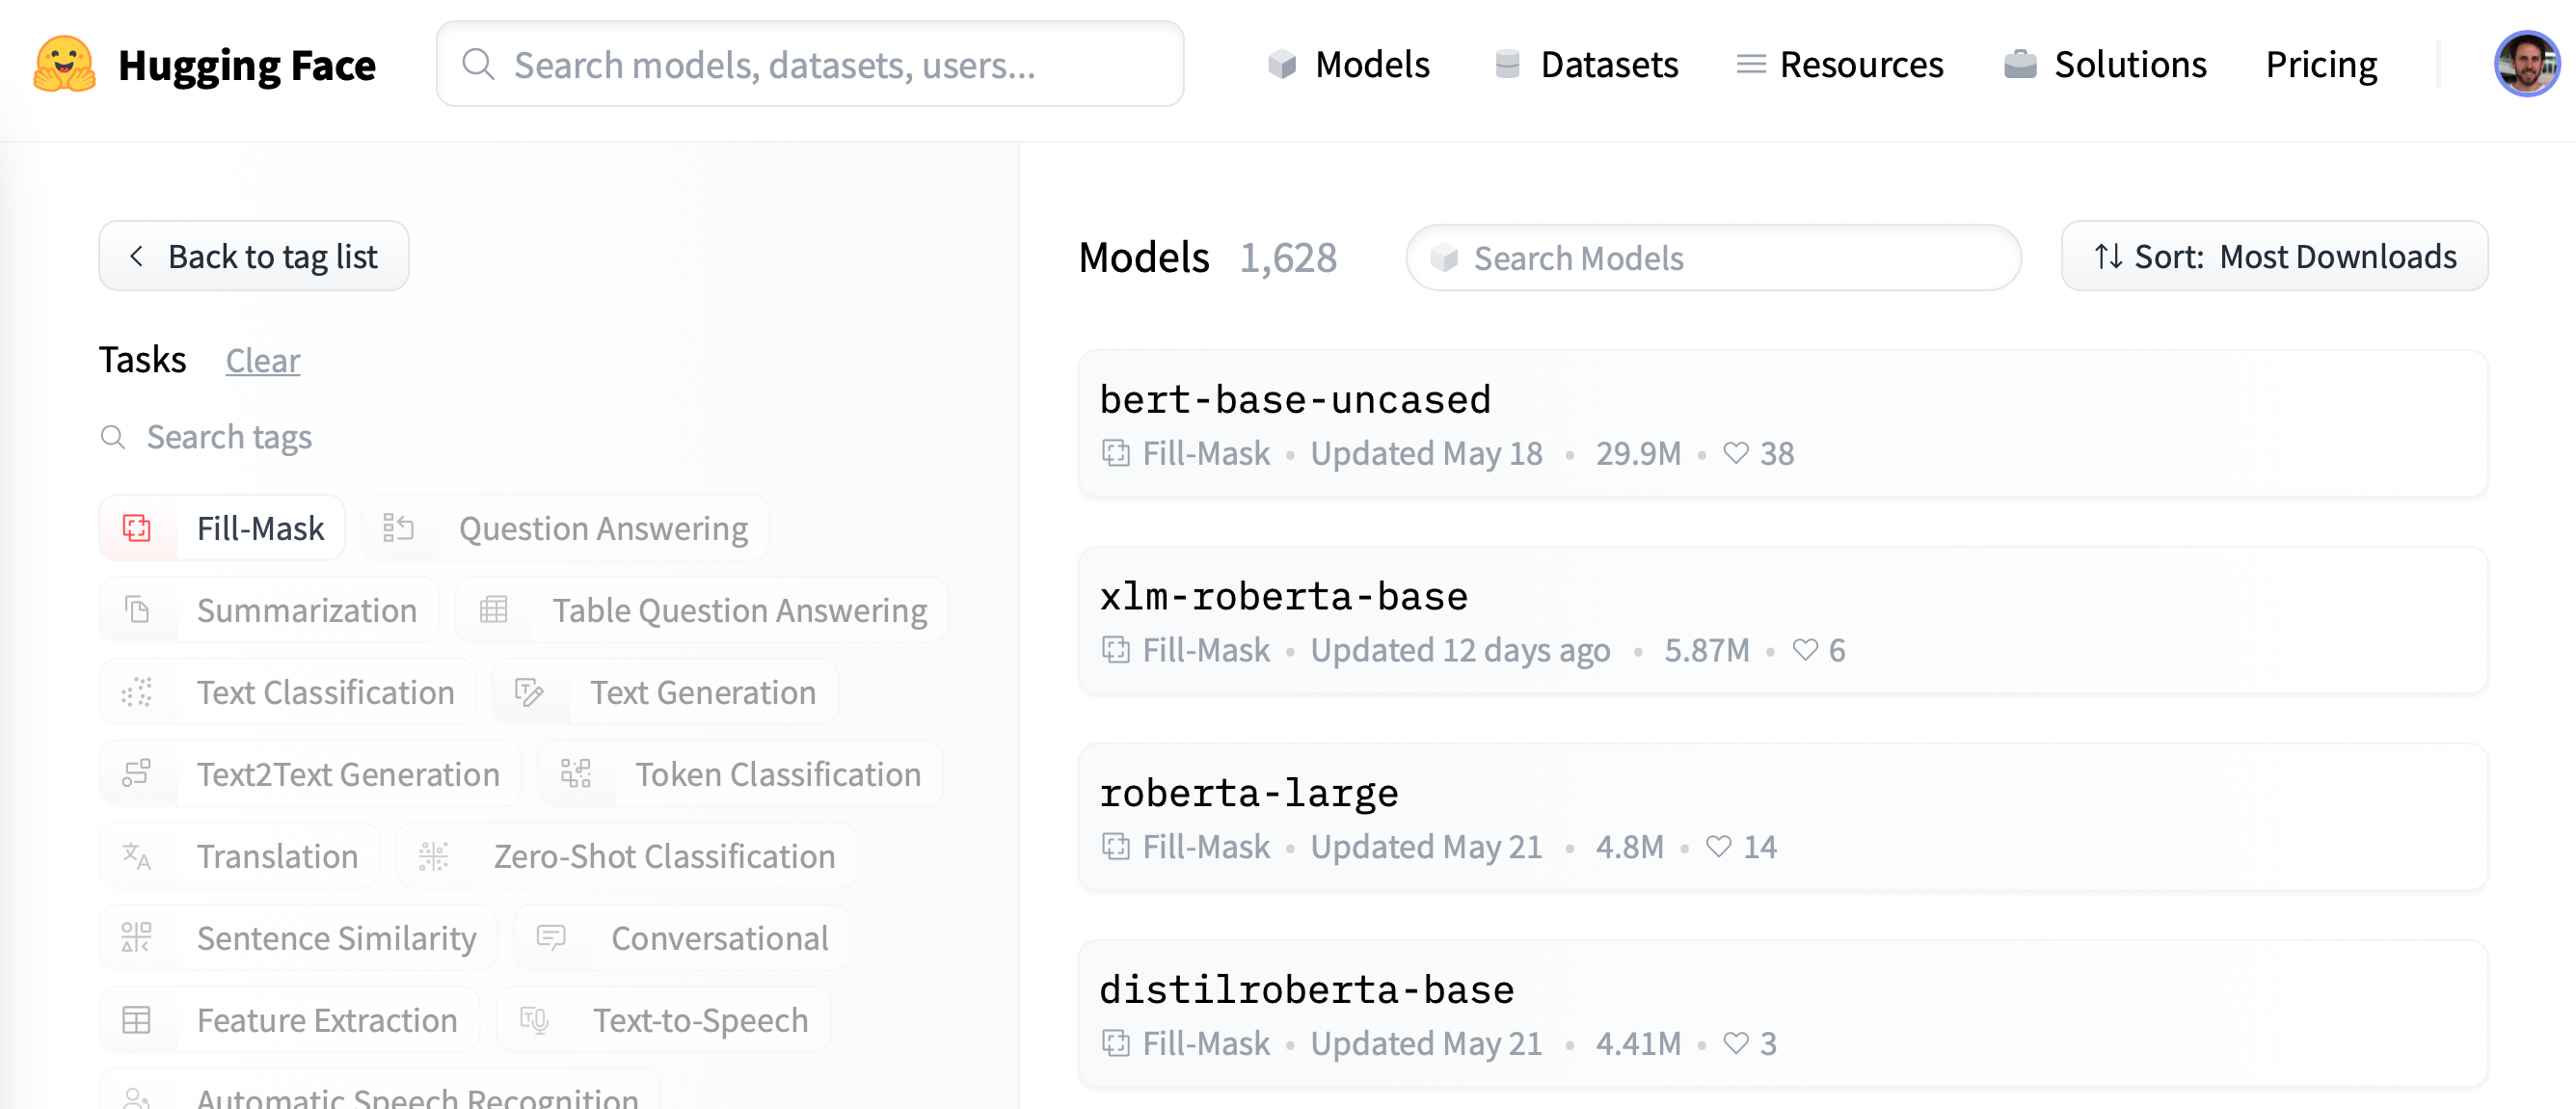

Although the BERT and RoBERTa family of models are the most downloaded, we’ll use a model called DistilBERT that can be trained much faster with little to no loss in downstream performance. This model was trained using a special technique called [knowledge distillation](https://en.wikipedia.org/wiki/Knowledge_distillation), where a large “teacher model” like BERT is used to guide the training of a “student model” that has far fewer parameters. An explanation of the details of knowledge distillation would take us too far afield in this section, but if you’re interested you can read all about it in [Natural Language Processing with Transformers](https://www.oreilly.com/library/view/natural-language-processing/9781098136789/) (colloquially known as the Transformers textbook).

Let’s go ahead and download DistilBERT using the `AutoModelForMaskedLM` class:

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
Tesla P40


In [2]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

We can see how many parameters this model has by calling the num_parameters() method:

In [3]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'


With around 67 million parameters, DistilBERT is approximately two times smaller than the BERT base model, which roughly translates into a two-fold speedup in training — nice! Let’s now see what kinds of tokens this model predicts are the most likely completions of a small sample of text:

In [4]:
text = "This is a great [MASK]."

As humans, we can imagine many possibilities for the `[MASK]` token, such as “day”, “ride”, or “painting”. For pretrained models, the predictions depend on the corpus the model was trained on, since it learns to pick up the statistical patterns present in the data. Like BERT, DistilBERT was pretrained on the [English Wikipedia](https://huggingface.co/datasets/wikipedia) and [BookCorpus](https://huggingface.co/datasets/bookcorpus) datasets, so we expect the predictions for [MASK] to reflect these domains. To predict the mask we need DistilBERT’s tokenizer to produce the inputs for the model, so let’s download that from the Hub as well:

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


With a tokenizer and a model, we can now pass our text example to the model, extract the logits, and print out the top 5 candidates:

In [6]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'


We can see from the outputs that the model’s predictions refer to everyday terms, which is perhaps not surprising given the foundation of English Wikipedia. Let’s see how we can change this domain to something a bit more niche — highly polarized movie reviews!

## The dataset

To showcase domain adaptation, we’ll use the famous [Large Movie Review Dataset](https://huggingface.co/datasets/imdb) (or IMDb for short), which is a corpus of movie reviews that is often used to benchmark sentiment analysis models. By fine-tuning DistilBERT on this corpus, we expect the language model will adapt its vocabulary from the factual data of Wikipedia that it was pretrained on to the more subjective elements of movie reviews. We can get the data from the Hugging Face Hub with the `load_dataset()` function from 🤗 Datasets:

In [7]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

We can see that the `train` and `test` splits each consist of 25,000 reviews, while there is an unlabeled split called `unsupervised` that contains 50,000 reviews. Let’s take a look at a few samples to get an idea of what kind of text we’re dealing with. As we’ve done in previous chapters of the course, we’ll chain the `Dataset.shuffle()` and `Dataset.select()` functions to create a random sample:

In [8]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'
'>>> Label: 1'

'>>> Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stu

Yep, these are certainly movie reviews, and if you’re old enough you may even understand the comment in the last review about owning a VHS version 😜! Although we won’t need the labels for language modeling, we can already see that a 0 denotes a negative review, while a 1 corresponds to a positive one.

Now that we’ve had a quick look at the data, let’s dive into preparing it for masked language modeling. As we’ll see, there are some additional steps that one needs to take compared to the sequence classification tasks we saw in [Chapter 3](https://huggingface.co/course/chapter3). Let’s go!

## Preprocessing the data

For both auto-regressive and masked language modeling, a common preprocessing step is to concatenate all the examples and then split the whole corpus into chunks of equal size. This is quite different from our usual approach, where we simply tokenize individual examples. Why concatenate everything together? The reason is that individual examples might get truncated if they’re too long, and that would result in losing information that might be useful for the language modeling task!

So to get started, we’ll first tokenize our corpus as usual, but without setting the `truncation=True` option in our tokenizer. We’ll also grab the word IDs if they are available ((which they will be if we’re using a fast tokenizer, as described in [Chapter 6](https://huggingface.co/course/chapter6/3)), as we will need them later on to do whole word masking. We’ll wrap this in a simple function, and while we’re at it we’ll remove the `text` and `label` columns since we don’t need them any longer:

In [9]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 50000
    })
})

Since DistilBERT is a BERT-like model, we can see that the encoded texts consist of the `input_ids` and `attention_mask` that we’ve seen in other chapters, as well as the `word_ids` we added.

Now that we’ve tokenized our movie reviews, the next step is to group them all together and split the result into chunks. But how big should these chunks be? This will ultimately be determined by the amount of GPU memory that you have available, but a good starting point is to see what the model’s maximum context size is. This can be inferred by inspecting the `model_max_length` attribute of the tokenizer:

In [10]:
tokenizer.model_max_length

512

This value is derived from the *tokenizer_config.json* file associated with a checkpoint; in this case we can see that the context size is 512 tokens, just like with BERT.

✏️ Try it out! Some Transformer models, like [BigBird](https://huggingface.co/google/bigbird-roberta-base) and [Longformer](https://huggingface.co/learn/nlp-course/chapter7/hf.co/allenai/longformer-base-4096), have a much longer context length than BERT and other early Transformer models. Instantiate the tokenizer for one of these checkpoints and verify that the `model_max_length` agrees with what’s quoted on its model card.

So, in order to run our experiments on GPUs like those found on Google Colab, we’ll pick something a bit smaller that can fit in memory:

In [11]:
chunk_size = 128

Note that using a small chunk size can be detrimental in real-world scenarios, so you should use a size that corresponds to the use case you will apply your model to.

Now comes the fun part. To show how the concatenation works, let’s take a few reviews from our tokenized training set and print out the number of tokens per review:

In [12]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 363'
'>>> Review 1 length: 304'
'>>> Review 2 length: 133'


We can then concatenate all these examples with a simple dictionary comprehension, as follows:

In [13]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 800'


Great, the total length checks out — so now let’s split the concatenated reviews into chunks of the size given by chunk_size. To do so, we iterate over the features in concatenated_examples and use a list comprehension to create slices of each feature. The result is a dictionary of chunks for each feature:

In [14]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 32'


As you can see in this example, the last chunk will generally be smaller than the maximum chunk size. There are two main strategies for dealing with this:

- Drop the last chunk if it’s smaller than `chunk_size`.

- Pad the last chunk until its length equals `chunk_size`.

We’ll take the first approach here, so let’s wrap all of the above logic in a single function that we can apply to our tokenized datasets:

In [15]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

Note that in the last step of `group_texts()` we create a new `labels` column which is a copy of the `input_ids` one. As we’ll see shortly, that’s because in masked language modeling the objective is to predict randomly masked tokens in the input batch, and by creating a `labels` column we provide the ground truth for our language model to learn from.

Let’s now apply `group_texts()` to our tokenized datasets using our trusty `Dataset.map()` function:

In [16]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 61291
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 59904
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 122957
    })
})

You can see that grouping and then chunking the texts has produced many more examples than our original 25,000 for the `train` and `test` splits. That’s because we now have examples involving contiguous tokens that span across multiple examples from the original corpus. You can see this explicitly by looking for the special `[SEP]` and `[CLS]` tokens in one of the chunks:

In [17]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

"as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema. even ingmar bergman,"

As expected from our `group_texts()` function above, this looks identical to the decoded input_ids — but then how can our model possibly learn anything? We’re missing a key step: inserting [MASK] tokens at random positions in the inputs! Let’s see how we can do this on the fly during fine-tuning using a special data collator.

##  Fine-tuning DistilBERT with the Trainer API

Fine-tuning a masked language model is almost identical to fine-tuning a sequence classification model, like we did in [Chapter 3](https://huggingface.co/course/chapter3). The only difference is that we need a special data collator that can randomly mask some of the tokens in each batch of texts. Fortunately, 🤗 Transformers comes prepared with a dedicated `DataCollatorForLanguageModeling` for just this task. We just have to pass it the tokenizer and an `mlm_probability` argument that specifies what fraction of the tokens to mask. We’ll pick 15%, which is the amount used for BERT and a common choice in the literature:

In [18]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

To see how the random masking works, let’s feed a few examples to the data collator. Since it expects a list of `dicts`, where each `dict` represents a single chunk of contiguous text, we first iterate over the dataset before feeding the batch to the collator. We remove the "word_ids" key for this data collator as it does not expect it:

In [19]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i rented i am [MASK] - [MASK] [MASK] my video store because of all the [MASK] that surrounded it when it was first released in 1967. i also heard that at first it was [MASK] by u. [MASK]. customs if it ever [MASK] to enter this country, therefore being a fan of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot [MASK] [MASK] around a young swedish drama [MASK] named lena who wants [MASK] learn everything she can [MASK] life. [MASK] particular she wants to focus her [MASK] [MASK] [MASK] making some sort of documentary on what the average swede thought about certain [MASK] issues such'

'>>> as [MASK] vietnam war and race issues in the united states. in between asking politicians and [MASK] denizens of stockholm about their opinions on politics, [MASK] [MASK] [MASK] with her drama teacher, classmates [MASK] and married men. < br / > < br / > patients kills [MASK] about i am curious - yellow is that 40 years ago [MASK] this was c

Nice, it worked! We can see that the [MASK] token has been randomly inserted at various locations in our text. These will be the tokens which our model will have to predict during training — and the beauty of the data collator is that it will randomize the [MASK] insertion with every batch!

One side effect of random masking is that our evaluation metrics will not be deterministic when using the `Trainer`, since we use the same data collator for the training and test sets. We’ll see later, when we look at fine-tuning with 🤗 Accelerate, how we can use the flexibility of a custom evaluation loop to freeze the randomness.

When training models for masked language modeling, one technique that can be used is to mask whole words together, not just individual tokens. This approach is called whole word masking. If we want to use whole word masking, we will need to build a data collator ourselves. A data collator is just a function that takes a list of samples and converts them into a batch, so let’s do this now! We’ll use the word IDs computed earlier to make a map between word indices and the corresponding tokens, then randomly decide which words to mask and apply that mask on the inputs. Note that the labels are all `-100` except for the ones corresponding to mask words.

In [20]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

Next, we can try it on the same samples as before:

In [21]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i [MASK] i am [MASK] - yellow from my video store because of [MASK] the controversy that [MASK] it [MASK] it was first released in 1967. i [MASK] heard that at first [MASK] was seized by u. s. customs if it ever tried to enter this country, therefore [MASK] a fan [MASK] films [MASK] [MASK] controversial " i really [MASK] to see this for [MASK]. < br / > < [MASK] / > the plot is [MASK] around a young swedish drama student [MASK] lena who wants [MASK] [MASK] [MASK] she can about [MASK]. in particular [MASK] wants [MASK] focus her attentions to making some sort of documentary on [MASK] [MASK] average [MASK] [MASK] thought about certain political [MASK] such'

'>>> as the vietnam war [MASK] [MASK] issues in the united states. in between asking politicians and ordinary denizens [MASK] stockholm about [MASK] opinions [MASK] politics, she has sex with [MASK] drama teacher, [MASK], [MASK] married men. < br / > < br / > what kills me about i am [MASK] - [MASK] is that 40 years ago [

Now that we have two data collators, the rest of the fine-tuning steps are standard. Training can take a while on Google Colab if you’re not lucky enough to score a mythical P100 GPU 😭, so we’ll first downsample the size of the training set to a few thousand examples. Don’t worry, we’ll still get a pretty decent language model! A quick way to downsample a dataset in 🤗 Datasets is via the `Dataset.train_test_split()` function that we saw in [Chapter 5](https://huggingface.co/course/chapter5):

In [22]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1000
    })
})

This has automatically created new train and test splits, with the training set size set to 10,000 examples and the validation set to 10% of that — feel free to increase this if you have a beefy GPU! The next thing we need to do is log in to the Hugging Face Hub. If you’re running this code in a notebook, you can do so with the following utility function:

```
from huggingface_hub import notebook_login

notebook_login()
```

from huggingface_hub import notebook_login: `notebook_login()`

in your favorite terminal and log in there.

Once we’re logged in, we can specify the arguments for the `Trainer`:

In [23]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


We now have all the ingredients to instantiate the Trainer. Here we just use the standard data_collator, but you can try the whole word masking collator and compare the results as an exercise:

In [24]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

###  Perplexity for language models

A lower perplexity score means a better language model, and we can see here that our starting model has a somewhat large value. Let’s see if we can lower it by fine-tuning! To do that, we first run the training loop:

In [25]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 21.94


We’re now ready to run `trainer.train()` — but before doing so let’s briefly look at perplexity, which is a common metric to evaluate the performance of language models.

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,2.680500,2.513249,0.003500
2,2.589900,2.450035,0.003500
3,2.528600,2.481905,0.003500


TrainOutput(global_step=471, training_loss=2.5992875595254756, metrics={'train_runtime': 283.8407, 'train_samples_per_second': 105.693, 'train_steps_per_second': 1.659, 'total_flos': 994208670720000.0, 'train_loss': 2.5992875595254756, 'epoch': 3.0})

and then compute the resulting perplexity on the test set as before:

In [27]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 12.06


Nice — this is quite a reduction in perplexity, which tells us the model has learned something about the domain of movie reviews!

Once training is finished, we can push the model card with the training information to the Hub (the checkpoints are saved during training itself): `trainer.push_to_hub()`

In our use case we didn’t need to do anything special with the training loop, but in some cases you might need to implement some custom logic. For these applications, you can use 🤗 Accelerate — let’s take a look!

##  Using our fine-tuned model

You can interact with your fine-tuned model either by using its widget on the Hub or locally with the pipeline from 🤗 Transformers. Let’s use the latter to download our model using the fill-mask pipeline:

In [28]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="distilbert-base-uncased-finetuned-imdb"
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


We can then feed the pipeline our sample text of “This is a great [MASK]” and see what the top 5 predictions are:

In [29]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

>>> this is a great film.
>>> this is a great movie.
>>> this is a great idea.
>>> this is a great one.
>>> this is a great deal.


Neat — our model has clearly adapted its weights to predict words that are more strongly associated with movies!

This wraps up our first experiment with training a language model. In section 6 you’ll learn how to train an auto-regressive model like GPT-2 from scratch; head over there if you’d like to see how you can pretrain your very own Transformer model!

✏️ Try it out! To quantify the benefits of domain adaptation, fine-tune a classifier on the IMDb labels for both the pretrained and fine-tuned DistilBERT checkpoints. If you need a refresher on text classification, check out [Chapter 3](https://huggingface.co/course/chapter3).

##  Fine-tuning DistilBERT with 🤗 Accelerate

As we saw with the `Trainer`, fine-tuning a masked language model is very similar to the text classification example from [Chapter 3](https://huggingface.co/course/chapter3). In fact, the only subtlety is the use of a special data collator, and we’ve already covered that earlier in this section!

However, we saw that `DataCollatorForLanguageModeling` also applies random masking with each evaluation, so we’ll see some fluctuations in our perplexity scores with each training run. One way to eliminate this source of randomness is to apply the masking once on the whole test set, and then use the default data collator in 🤗 Transformers to collect the batches during evaluation. To see how this works, let’s implement a simple function that applies the masking on a batch, similar to our first encounter with `DataCollatorForLanguageModeling`:

In [30]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

Next, we’ll apply this function to our test set and drop the unmasked columns so we can replace them with the masked ones. You can use whole word masking by replacing the `data_collator` above with the appropriate one, in which case you should remove the first line here:

In [31]:
downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

We can then set up the dataloaders as usual, but we’ll use the `default_data_collator` from 🤗 Transformers for the evaluation set:

In [32]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

Form here, we follow the standard steps with 🤗 Accelerate. The first order of business is to load a fresh version of the pretrained model:

In [33]:
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

Then we need to specify the optimizer; we’ll use the standard `AdamW`:

In [34]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [35]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

With these objects, we can now prepare everything for training with the `Accelerator` object:

In [36]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

Now that our model, optimizer, and dataloaders are configured, we can specify the learning rate scheduler as follows:

In [37]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

There is just one last thing to do before training: create a model repository on the Hugging Face Hub! We can use the 🤗 Hub library to first generate the full name of our repo:

```python
from huggingface_hub import get_full_repo_name

model_name = "distilbert-base-uncased-finetuned-imdb-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name
```

then create and clone the repository using the Repository class from 🤗 Hub:

```python
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)
```

With that done, it’s just a simple matter of writing out the full training and evaluation loop:

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # # Save and upload
    # accelerator.wait_for_everyone()
    # unwrapped_model = accelerator.unwrap_model(model)
    # unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    # if accelerator.is_main_process:
    #     tokenizer.save_pretrained(output_dir)
    #     repo.push_to_hub(
    #         commit_message=f"Training in progress epoch {epoch}", blocking=False
    #     )

Cool, we’ve been able to evaluate perplexity with each epoch and ensure that multiple training runs are reproducible!